In [1]:
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical
import keras.backend as K
from functools import partial
import pandas as pd
from gensim.models import word2vec
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2), K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

def weight_variable(shape):
    return K.truncated_normal(shape, stddev = 0.01)

In [3]:
#学習済みモデルのロード
embeddings_model = word2vec.Word2Vec.load('Datas/Word2Vec_model/dD.model')
#データの読み込み
use_data = pd.read_csv(filepath_or_buffer="Datas/A_pickup_data.csv", encoding="utf_8", sep=",")
print(len(use_data))
use_data.info()

/Users/swallowtail/.local/share/virtualenvs/classification_tweet-zASJ7jKU/lib/python3.6/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


20000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
screen_name    20000 non-null object
user_id        20000 non-null float64
tweet_id       20000 non-null float64
tweet          20000 non-null object
tweet2         20000 non-null object
postdate       20000 non-null object
cos_day        20000 non-null float64
sin_day        20000 non-null float64
tag            20000 non-null object
image_url      20000 non-null object
image          20000 non-null int64
retweet        20000 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 1.8+ MB


In [4]:
maxlen = 50
train = 0.7
validation = 0.1
max_words = 25000

#データをランダムにシャッフル
use_data_s = use_data.sample(frac=1, random_state=150)

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(use_data_s['tweet2'])
sequences = tokenizer.texts_to_sequences(use_data_s['tweet2'])

word_index = tokenizer.word_index
num_words = len(word_index)

print("Found {} unique tokens.".format(len(word_index)))

embedding_matrix = np.zeros((num_words+1, 50))
for word, i in word_index.items():
    if word in embeddings_model.wv.index2word:
        embedding_matrix[i] = embeddings_model[word]

data = pad_sequences(sequences, maxlen=maxlen)

# バイナリの行列に変換
categorical_labels = to_categorical(use_data_s['retweet'])
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(labels.shape))

indices = [int(len(labels) * n) for n in [train, train + validation]]
x_train, x_val, x_test = np.split(data, indices)
y_train, y_val, y_test = np.split(labels, indices)

Found 23377 unique tokens.


/Users/swallowtail/.local/share/virtualenvs/classification_tweet-zASJ7jKU/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Shape of data tensor:(20000, 50)
Shape of label tensor:(20000, 2)


In [5]:
p_input = Input(shape=(50, ), dtype='int32', name='input_postText')

em = Embedding(input_dim=num_words+1, output_dim=50, input_length=50, weights=[embedding_matrix], trainable=False)(p_input)
d_em = Dropout(0.5)(em)
lstm_out = LSTM(32, kernel_initializer=weight_variable)(d_em)
d_lstm_out = Dropout(0.5)(lstm_out)
output = Dense(2, activation='softmax', name = 'output')(d_lstm_out)

model = Model(inputs=p_input, outputs = output)
optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=['acc', macro_precision, macro_recall, macro_f_measure])
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_image/model1.png')

early_stopping = EarlyStopping(patience=5, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_postText (InputLayer)  (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1168900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 66        
Total params: 1,179,590
Trainable params: 10,690
Non-trainable params: 1,168,900
_____________________________________________________________

In [6]:
history = model.fit(x_train, y_train,
                    epochs=100, 
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

Train on 14000 samples, validate on 1999 samples
Epoch 1/100
14000/14000 [==============================] - 5s 337us/step - loss: 0.6789 - acc: 0.5483 - macro_precision: 0.5534 - macro_recall: 0.5470 - macro_f_measure: 0.5502 - val_loss: 0.6660 - val_acc: 0.5883 - val_macro_precision: 0.5989 - val_macro_recall: 0.5910 - val_macro_f_measure: 0.5949
Epoch 2/100
14000/14000 [==============================] - 4s 288us/step - loss: 0.6483 - acc: 0.6178 - macro_precision: 0.6295 - macro_recall: 0.6199 - macro_f_measure: 0.6246 - val_loss: 0.6325 - val_acc: 0.6503 - val_macro_precision: 0.6858 - val_macro_recall: 0.6458 - val_macro_f_measure: 0.6652
Epoch 3/100
14000/14000 [==============================] - 4s 296us/step - loss: 0.6165 - acc: 0.6450 - macro_precision: 0.6794 - macro_recall: 0.6465 - macro_f_measure: 0.6625 - val_loss: 0.5960 - val_acc: 0.6738 - val_macro_precision: 0.7147 - val_macro_recall: 0.6691 - val_macro_f_measure: 0.6911
Epoch 4/100
14000/14000 [=======================

Epoch 28/100
14000/14000 [==============================] - 4s 251us/step - loss: 0.5248 - acc: 0.7284 - macro_precision: 0.7308 - macro_recall: 0.7284 - macro_f_measure: 0.7296 - val_loss: 0.5142 - val_acc: 0.7369 - val_macro_precision: 0.7380 - val_macro_recall: 0.7360 - val_macro_f_measure: 0.7370
Epoch 29/100
14000/14000 [==============================] - 4s 272us/step - loss: 0.5204 - acc: 0.7327 - macro_precision: 0.7350 - macro_recall: 0.7326 - macro_f_measure: 0.7338 - val_loss: 0.5141 - val_acc: 0.7389 - val_macro_precision: 0.7409 - val_macro_recall: 0.7376 - val_macro_f_measure: 0.7393
Epoch 30/100
14000/14000 [==============================] - 4s 309us/step - loss: 0.5205 - acc: 0.7286 - macro_precision: 0.7307 - macro_recall: 0.7290 - macro_f_measure: 0.7299 - val_loss: 0.5139 - val_acc: 0.7379 - val_macro_precision: 0.7412 - val_macro_recall: 0.7360 - val_macro_f_measure: 0.7386
Epoch 31/100
14000/14000 [==============================] - 5s 360us/step - loss: 0.5222 - acc

14000/14000 [==============================] - 6s 457us/step - loss: 0.5100 - acc: 0.7414 - macro_precision: 0.7441 - macro_recall: 0.7416 - macro_f_measure: 0.7428 - val_loss: 0.5047 - val_acc: 0.7474 - val_macro_precision: 0.7522 - val_macro_recall: 0.7458 - val_macro_f_measure: 0.7490
Epoch 56/100
14000/14000 [==============================] - 7s 470us/step - loss: 0.5096 - acc: 0.7404 - macro_precision: 0.7437 - macro_recall: 0.7415 - macro_f_measure: 0.7426 - val_loss: 0.5047 - val_acc: 0.7484 - val_macro_precision: 0.7530 - val_macro_recall: 0.7467 - val_macro_f_measure: 0.7498
Epoch 57/100
14000/14000 [==============================] - 5s 371us/step - loss: 0.5114 - acc: 0.7412 - macro_precision: 0.7444 - macro_recall: 0.7415 - macro_f_measure: 0.7429 - val_loss: 0.5097 - val_acc: 0.7459 - val_macro_precision: 0.7570 - val_macro_recall: 0.7434 - val_macro_f_measure: 0.7501
Epoch 58/100
14000/14000 [==============================] - 7s 471us/step - loss: 0.5102 - acc: 0.7394 - ma

14000/14000 [==============================] - 4s 261us/step - loss: 0.5042 - acc: 0.7457 - macro_precision: 0.7484 - macro_recall: 0.7461 - macro_f_measure: 0.7472 - val_loss: 0.5009 - val_acc: 0.7529 - val_macro_precision: 0.7584 - val_macro_recall: 0.7513 - val_macro_f_measure: 0.7548
Epoch 83/100
14000/14000 [==============================] - 5s 383us/step - loss: 0.5053 - acc: 0.7429 - macro_precision: 0.7458 - macro_recall: 0.7433 - macro_f_measure: 0.7445 - val_loss: 0.5009 - val_acc: 0.7504 - val_macro_precision: 0.7550 - val_macro_recall: 0.7489 - val_macro_f_measure: 0.7519
Epoch 84/100
14000/14000 [==============================] - 6s 420us/step - loss: 0.5024 - acc: 0.7464 - macro_precision: 0.7490 - macro_recall: 0.7471 - macro_f_measure: 0.7481 - val_loss: 0.4993 - val_acc: 0.7474 - val_macro_precision: 0.7507 - val_macro_recall: 0.7462 - val_macro_f_measure: 0.7484
Epoch 85/100
14000/14000 [==============================] - 4s 287us/step - loss: 0.4999 - acc: 0.7457 - ma

In [7]:
loss_and_metrics = model.evaluate(x_test, y_test)
print(loss_and_metrics)

4001/4001 [==============================] - 1s 272us/step
[0.49023836599888687, 0.759810047488128, 0.7614831597737687, 0.758882307091584, 0.7600942524156997]


In [21]:
classes = model.predict(x_test)
np.savetxt('Datas/result/model1_dC_predict.csv', classes, delimiter = ',')

In [22]:
model.save('Datas/models/model1_dC.h5')

<Figure size 432x288 with 0 Axes>

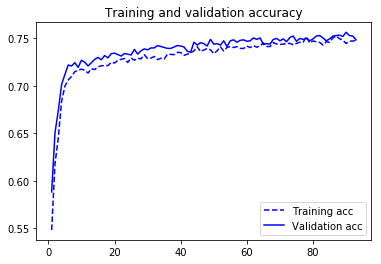

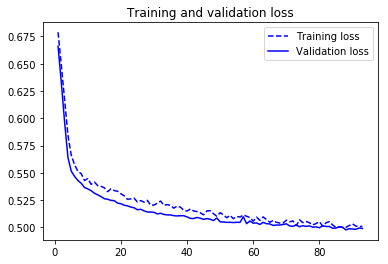

<Figure size 432x288 with 0 Axes>

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig("Datas/Figs/C/test_and_val_acc.png")

plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig("Datas/Figs/C/test_and_val_loss.png")

plt.figure()

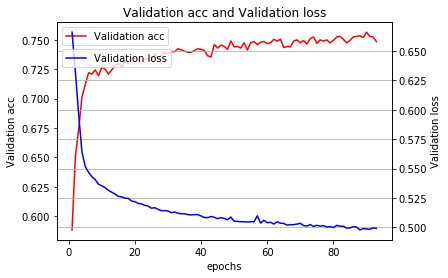

In [9]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'r', label='Validation acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)
ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Validation acc and Validation loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Validation acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Validation loss')
#plt.savefig("Datas/Figs/C/val_acc_loss.png")
plt.show()